In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import math
from scipy.stats import ks_2samp
from scipy.stats import chisquare

In [2]:
def generate_original_dataset():
    np.random.seed(42)
    num_samples = 500
    df = pd.DataFrame(
    {
    "Category1": np.random.choice(["A", "B", "C", "D", "E"],
    num_samples, p=[0.2, 0.4, 0.2, 0.1, 0.1]),
    "Value1": np.random.normal(10, 2,
    num_samples), # Continuous variable
    "Value2": np.random.normal(20, 6,
    num_samples), # Continuous variable
    }
    )
    df.to_csv("dataset.csv", sep=";")

In [3]:
# Exploratory Data Analysis of the Dataset as a whole
def explore_whole_dataset(df):
    ###################################### Category 1################################
    print("Category 1 Value Descriptive Statistics: \n",df["Category1"].describe())
    # Visualize the Distribution of Category 1 Values
    probabilities=df["Category1"].value_counts(normalize=True).sort_index()
    sb.barplot(x=probabilities.index,y=probabilities.values,hue= probabilities.index,palette='pastel')
    plt.title("Category 1 Probability Distribution")
    plt.xlabel("Value")
    plt.ylabel("Prabability")
    plt.show()
    ###################################### Value 1 and Value 2################################
    print("Value 1 - Descriptive Statistics: \n",df['Value1'].describe())
    print("Value 2 - Descriptive Statistics: \n",df['Value2'].describe())
    df[["Value1", "Value2"]].hist()

In [5]:
############### Analogy of the dataset ##############################################################
# This dataset can be interpreted as analogous to data from a bolt manufacturing plant.
# Category1  -->  Machine ID
# Value1     -->  Length of bolts (in cm)
# Value2     -->  Diameter of bolts (in mm)
######################################################################################################
# So, I analyzed the distributions of the continuous variables separately for each category.
# (Similar to analyzing the length and diameter of the bolts produced, machine wise)

In [4]:
# Descriptive Statistics of Value1 and Value2 for each category 
def show_statistics(df):
    categories=sorted(df["Category1"].unique())
    n = len(categories)

    for i,category in enumerate(categories):    
        df_category=df[df['Category1'] == category]
        value1_statistics=df_category['Value1'].describe()
        value2_statistics=df_category['Value2'].describe()
        combined_stats = pd.concat([value1_statistics, value2_statistics], axis=1)
        combined_stats.columns = ["Value1", "Value2"]
        print(f"\n========== Category {category} - Descriptive Statistics ==========")
        print(combined_stats.round(2))

In [5]:
# Visualizing the Value1, Value2 Distributions for each category
def plot_value_distributions(df):
    categories = sorted(df["Category1"].unique())
    n = len(categories)   
    print(f"\n========== Value1, Value2 Distributions per Category1 Value ==========")
    # 4 plots per row
    cols = 4
    rows = 2  
    fig, axes = plt.subplots(nrows=rows * 2, ncols=cols, figsize=(cols * 4, rows * 4), squeeze=False)

    for i, category in enumerate(categories):
        df_category = df[df['Category1'] == category]
        row = (i // cols) * 2
        col = i % cols

        sb.histplot(df_category["Value1"], ax=axes[row][col], color=sb.color_palette("tab10")[i])
        axes[row][col].set_title(f"Category {category} - Value1")

        sb.histplot(df_category["Value2"], ax=axes[row + 1][col],color=sb.color_palette("tab10")[i])
        axes[row + 1][col].set_title(f"Category {category} - Value2")

    # Hide empty plots
    for r in range(rows * 2):
        for c in range(cols):
            if r // 2 * cols + c >= n:
                axes[r][c].set_visible(False)

    plt.tight_layout()
    plt.show()


In [27]:
##################### Generate New Dataset using the characteristics of the original dataset ##########################
##############I decided to generate datasets for each category value and then combine those #######################
############### The new dataset has 1000 samples. Scaling factor is sent as a parameter. So the num_samples can be scaled as prefered##########

In [6]:
#Return mean and standard diviation of value1 and value 2 of each category 
#Needed to create a normally distributed dataset for each category
def get_category_stats(df_category):
    value1_mean = df_category['Value1'].mean()
    value1_std = df_category['Value1'].std()
    value2_mean = df_category['Value2'].mean()
    value2_std = df_category['Value2'].std()
    return value1_mean, value1_std, value2_mean, value2_std

In [7]:
def generate_column_data(mean, std, count):
    return np.random.normal(mean, std, count)

In [8]:
def create_category_dataframe(category, count, val1_data, val2_data):
    category_col = np.repeat(category, count)
    return pd.DataFrame({
        "Category1": category_col,
        "Value1": val1_data,
        "Value2": val2_data
    })

In [9]:
# Generate new dataset,sampling from normal distributions per category

def generate_new_dataset(df_original, scaling_factor):
    categories = sorted(df_original["Category1"].unique())
    df_list = []

    for category in categories:
        df_category = df_original[df_original['Category1'] == category]
        original_count = len(df_category)
        new_count = original_count * scaling_factor

        # Get means and 
        val1_mean, val1_std, val2_mean, val2_std = get_category_stats(df_category)

        # Generate new data
        value1_data = generate_column_data(val1_mean, val1_std, new_count)
        value2_data = generate_column_data(val2_mean, val2_std, new_count)

        # Create DataFrame for the category
        df_generated = create_category_dataframe(category, new_count, value1_data, value2_data)
        df_list.append(df_generated)

    # Concatenate all category dataframes
    df_new = pd.concat(df_list, ignore_index=True)
    df_new.to_csv("newdataset.csv", sep=";")

In [ ]:
############ Camparison of Original and New Datasets########################
# Similarity of two datasets can be checked visually by ploting probability densities and checking the descriptive statistics
# But verified using statistical tests

In [27]:
############## Compare probability Distrinbutions of the Categorical Variable Visually ##############################

In [10]:
def plot_category_probability_comparison(df_original, df_new):
    prob_original = df_original["Category1"].value_counts(normalize=True).sort_index()
    prob_new = df_new["Category1"].value_counts(normalize=True).sort_index()

    df_plot = pd.DataFrame({
        "Category": prob_original.index.tolist() * 2,
        "Probability": list(prob_original.values) + list(prob_new.values),
        "Dataset": ["Original"] * len(prob_original) + ["New"] * len(prob_new)
    })

    # Plot barplots in the same figure
    plt.figure(figsize=(8, 5))
    sb.barplot(data=df_plot, x="Category", y="Probability", hue="Dataset", palette="pastel")

    plt.title("Category1 Probability Distribution: Original vs New")
    plt.xlabel("Category1 Value")
    plt.ylabel("Probability")
    plt.tight_layout()
    plt.show()

In [ ]:
########### Compare Distribution of Value1 and Value2 - Original vs New - Visually ################
# KDE plots are used to visualize the probability densities of Value1 and Value2 of Original and New datasets
# KDE plots of continuous variables for both datasets are drawn in the same plot for clear comparison

In [11]:
def plot_continuous_value_comparison(df_original,df_new):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    #Value1 Plots
    sb.kdeplot(df_original["Value1"], color='r', fill=False, label='Original', ax=axes[0])
    sb.kdeplot(df_new["Value1"], color='b', fill=False, label='New', ax=axes[0])
    axes[0].set_title("Probability Distribution of Value1")
    axes[0].set_xlabel("Value1")
    axes[0].set_ylabel("Probability Density")
    axes[0].legend()

    # Value2 plots
    sb.kdeplot(df_original["Value2"], color='r', fill=False, label='Original', ax=axes[1])
    sb.kdeplot(df_new["Value2"], color='b', fill=False, label='New', ax=axes[1])
    axes[1].set_title("Probability Distribution of Value2")
    axes[1].set_xlabel("Value2")
    axes[1].set_ylabel("Probability Density")
    axes[1].legend()

    plt.tight_layout()
    plt.show()
    

In [ ]:
################# Discriptive Statistics Comparison #################

In [12]:
def compare_descriptive_statistics(df_original,df_new):
    value1_stats = pd.concat([
        df_original["Value1"].describe().rename("Original_Value1"),
        df_new["Value1"].describe().rename("New_Value1")
    ], axis=1).round(3)
    value2_stats = pd.concat([df_original["Value2"].describe().rename("Original_Value2"),
        df_new["Value2"].describe().rename("New_Value2")
    ], axis=1).round(3)

    print("\n====== Value1 Descriptive Statistics ======")
    print(value1_stats.to_string())

    print("\n====== Value2 Descriptive Statistics ======")
    print(value2_stats.to_string())


In [ ]:
####### Test the Similarity of New Data and Original Data using Statistical Tests#############
# Testing the similarity of continuos data (Value1, Value2) - Kolmogorov–Smirnov (KS) test is used
# t-test was also considered. But it was not used as it only tests whether the means of two variables are significantly different or not
# while KS test checks whether the samples have similar probability distributions
# Null Hypothesis(H0) - 
###############################################################################################

In [13]:
def test_continuous_values_similarity(df_original,df_new):
    # Null Hypothesis(H0) - Distribution of original and new datasets are same
    # Alternative Hypothesis(H1) - Distribution of original and new datasets are significantly diffferent
    columns=["Value1","Value2"]
    for col in columns:
        stat, p_value = ks_2samp(df_original[col], df_new[col])
        if p_value > 0.05:
            print(f"Distributions of {col} of two datasets are same as p_value={p_value} and it is greater than 0.05\n")
        else:
            print(f"Distributions of {col} of two datasetsare significantly different as p_value={p_value}\n")
    

In [14]:
####### Test the similarity of the distributions of categorical variable of two datasets#########
# Chi-square test is used to check the similarity
def test_categorical_values_similarity(df_original,df_new):
    original_counts = df_original["Category1"].value_counts().sort_index()
    new_counts = df_new["Category1"].value_counts().sort_index()

    # num_samples of the new dataset is different. So the count of the original dataset is scaled-up
    scaling_factor = new_counts.sum() / original_counts.sum()
    expected_counts = original_counts * scaling_factor

    stat, p_value = chisquare(f_obs=new_counts, f_exp=expected_counts)

    if p_value > 0.05:
        print(f"Distribution of Category1 of two datasets are statistically similar as p_value={p_value} and it is greater than 0.05\n" )
    else:
        print(f"Distribution of Category1 of two datasets are significantly different as p_value={p_value}\n")
    

In [74]:
##################################### Check Results ############################################
# 1. Generate Original Dataset
# 2. Explore the whole dataset - Plot probability distribution of the categorical variable and histograms of continuous values
# 3. Analyze descriptive statistics of continuous variables per each category
# 4. Plot distributions of continuous variables per each category
# 5. Generate New Dataset
# 6. Repeat step 1 to 4 - To get an idea about the new dataset
# 7. Visualize the Probablity Distributions of  the Categorical variable of New and Original datasets in the same plot
# 8. Visualize the Probablity Distributions of  the Continuous variables of New and Original datasets in the same plot
# 9. Read descriptive statistics of Continuous variables of New and Original datasets
# 10. Run Statistical Tests for similarity check - KS test for continuous values, Chi-square test for categorical values


In [17]:
#1
generate_original_dataset()
df_original=df_original=pd.read_csv("dataset.csv", sep=";")

Category 1 Value Descriptive Statistics: 
 count     500
unique      5
top         B
freq      179
Name: Category1, dtype: object


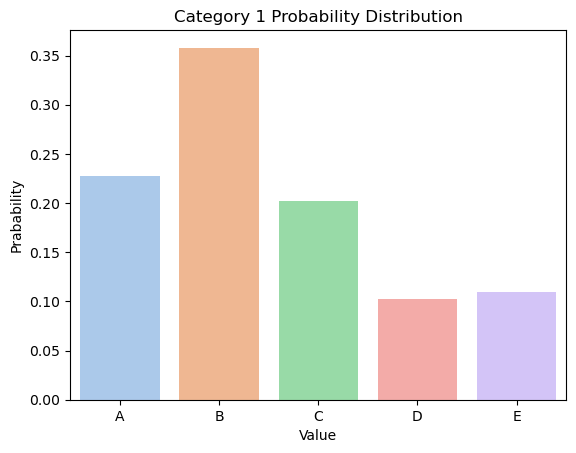

Value 1 - Descriptive Statistics: 
 count    500.000000
mean      10.015240
std        2.014124
min        4.606227
25%        8.698118
50%        9.934552
75%       11.322653
max       16.157762
Name: Value1, dtype: float64
Value 2 - Descriptive Statistics: 
 count    500.000000
mean      20.436278
std        5.972594
min        2.622468
25%       16.385422
50%       20.481394
75%       24.249024
max       35.478256
Name: Value2, dtype: float64


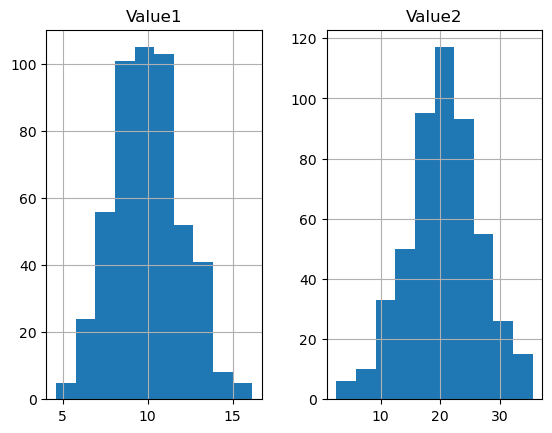

In [18]:
#2
explore_whole_dataset(df_original)

In [19]:
#3
show_statistics(df_original)


========== Category A - Descriptive Statistics ==========
       Value1  Value2
count  114.00  114.00
mean     9.68   19.84
std      2.03    6.04
min      5.85    2.91
25%      8.29   16.28
50%      9.55   19.68
75%     11.06   23.74
max     15.26   35.48

========== Category B - Descriptive Statistics ==========
       Value1  Value2
count  179.00  179.00
mean    10.06   20.06
std      1.80    5.85
min      4.70    2.62
25%      8.94   16.38
50%     10.05   20.06
75%     11.26   23.54
max     15.15   33.75

========== Category C - Descriptive Statistics ==========
       Value1  Value2
count  101.00  101.00
mean    10.37   20.71
std      2.04    6.36
min      4.61    5.46
25%      9.02   15.91
50%     10.50   21.18
75%     11.52   25.50
max     16.16   34.64

========== Category D - Descriptive Statistics ==========
       Value1  Value2
count   51.00   51.00
mean    10.40   22.26
std      2.39    5.57
min      6.68    7.08
25%      8.76   18.78
50%     10.03   22.69
75%     12.13   


========== Value1, Value2 Distributions per Category1 Value ==========


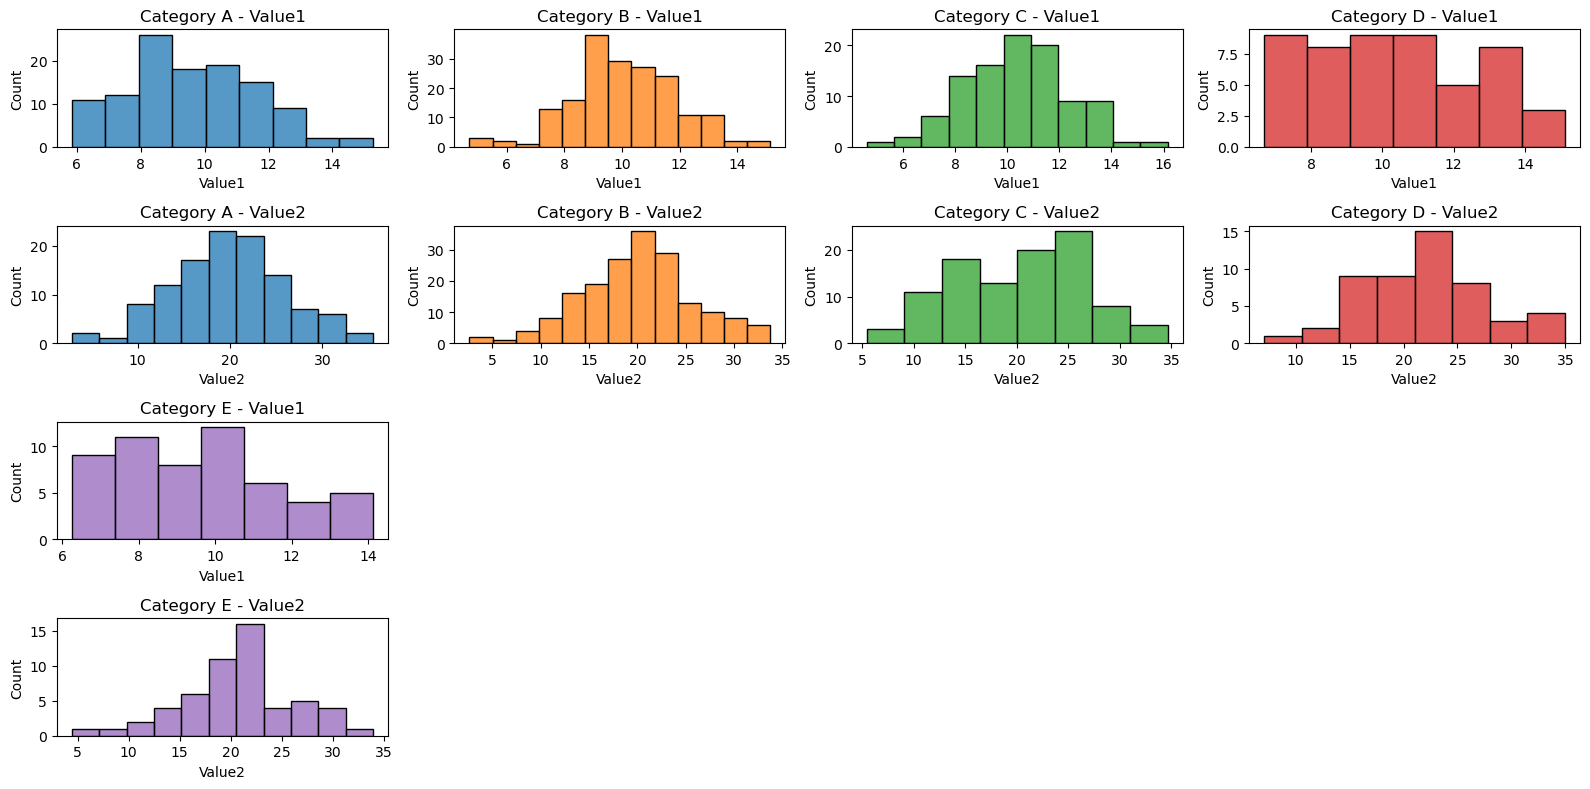

In [20]:
#4
plot_value_distributions(df_original)

In [21]:
#5
scaling_factor=2 
generate_new_dataset(df_original,2)
df_new=pd.read_csv("newdataset.csv", sep=";")

Category 1 Value Descriptive Statistics: 
 count     1000
unique       5
top          B
freq       358
Name: Category1, dtype: object


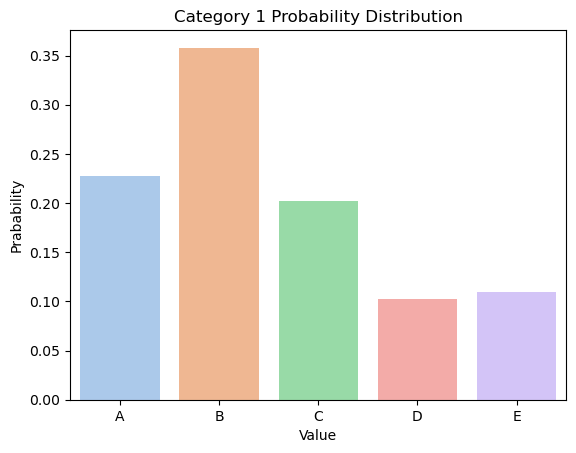

Value 1 - Descriptive Statistics: 
 count    1000.000000
mean       10.076641
std         2.006777
min         3.628921
25%         8.709636
50%        10.090003
75%        11.417895
max        16.162798
Name: Value1, dtype: float64
Value 2 - Descriptive Statistics: 
 count    1000.000000
mean       20.476859
std         5.947594
min         1.687126
25%        16.479078
50%        20.320410
75%        24.417716
max        45.689278
Name: Value2, dtype: float64


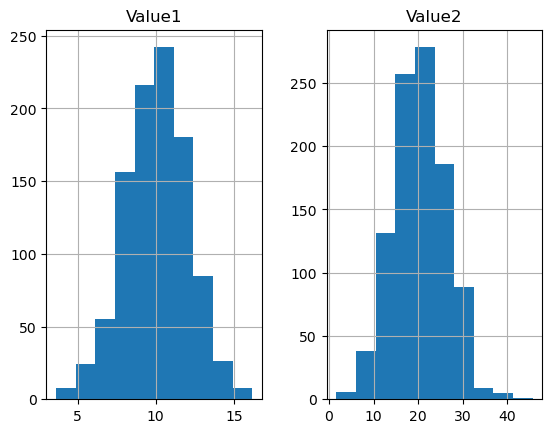

In [22]:
# 6.1 
explore_whole_dataset(df_new)

In [23]:
#6.2
show_statistics(df_new)


========== Category A - Descriptive Statistics ==========
       Value1  Value2
count  228.00  228.00
mean     9.84   20.25
std      2.08    5.79
min      3.75    3.52
25%      8.37   16.61
50%      9.80   20.18
75%     11.18   24.12
max     14.96   39.12

========== Category B - Descriptive Statistics ==========
       Value1  Value2
count  358.00  358.00
mean    10.05   20.21
std      1.77    5.79
min      4.61    4.65
25%      8.94   16.10
50%     10.03   20.18
75%     11.20   24.07
max     15.71   38.25

========== Category C - Descriptive Statistics ==========
       Value1  Value2
count  202.00  202.00
mean    10.59   20.35
std      1.95    6.39
min      5.20    1.69
25%      9.14   16.73
50%     10.76   19.56
75%     11.85   24.30
max     15.72   45.69

========== Category D - Descriptive Statistics ==========
       Value1  Value2
count  102.00  102.00
mean    10.02   21.81
std      2.40    5.59
min      3.63    6.06
25%      8.41   18.30
50%     10.07   22.00
75%     11.47   


========== Value1, Value2 Distributions per Category1 Value ==========


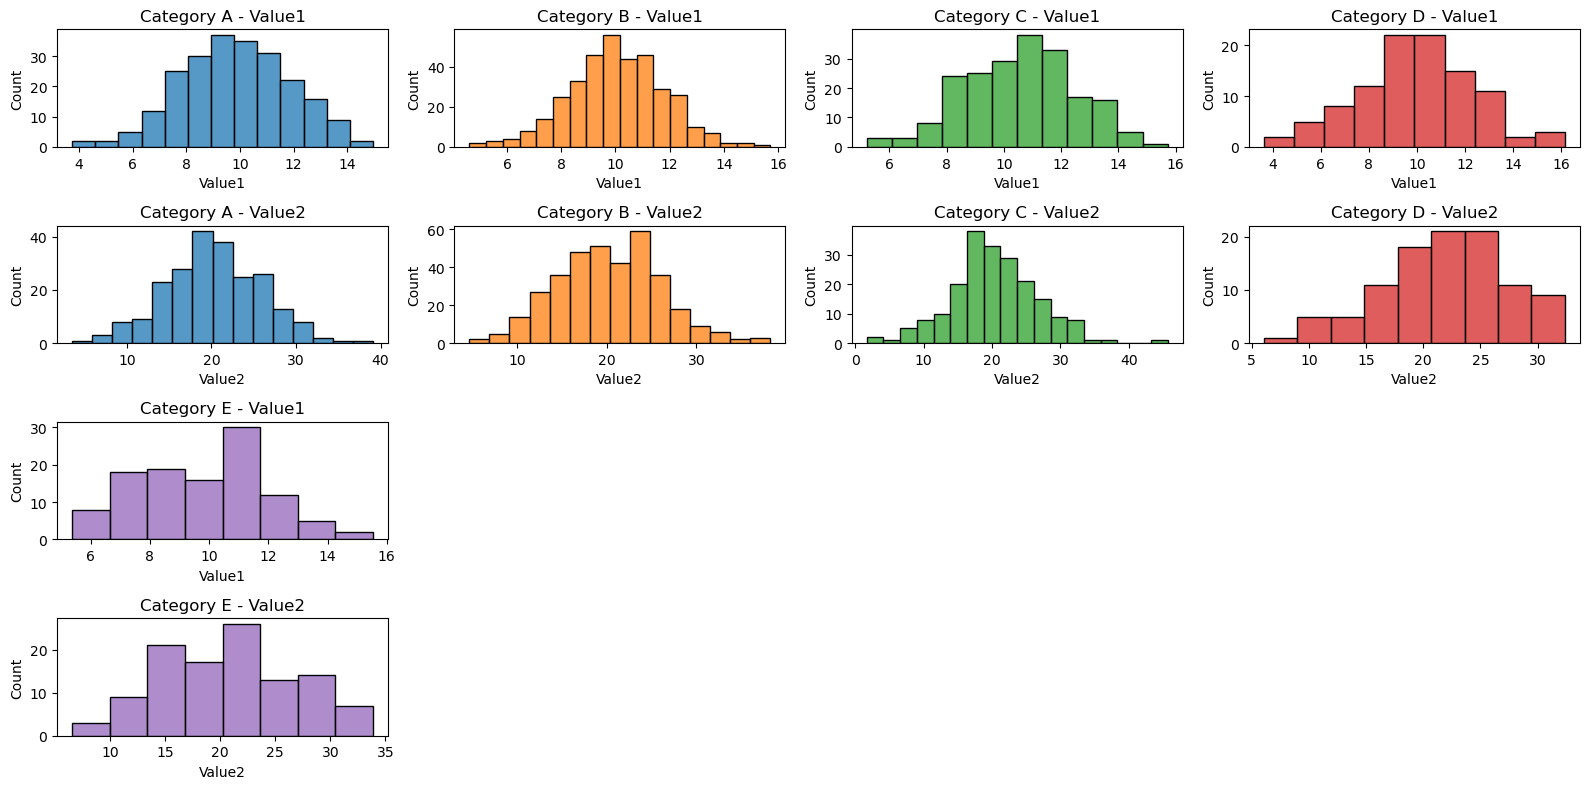

In [24]:
#6.3
plot_value_distributions(df_new)

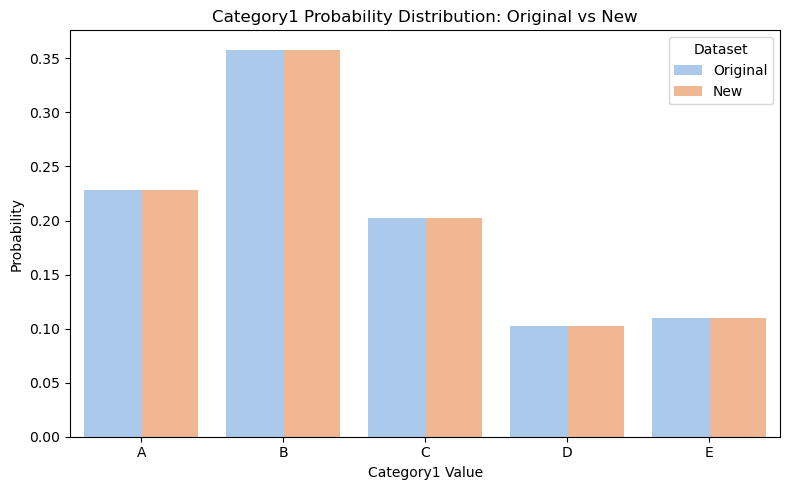

In [25]:
#7
plot_category_probability_comparison(df_original,df_new)

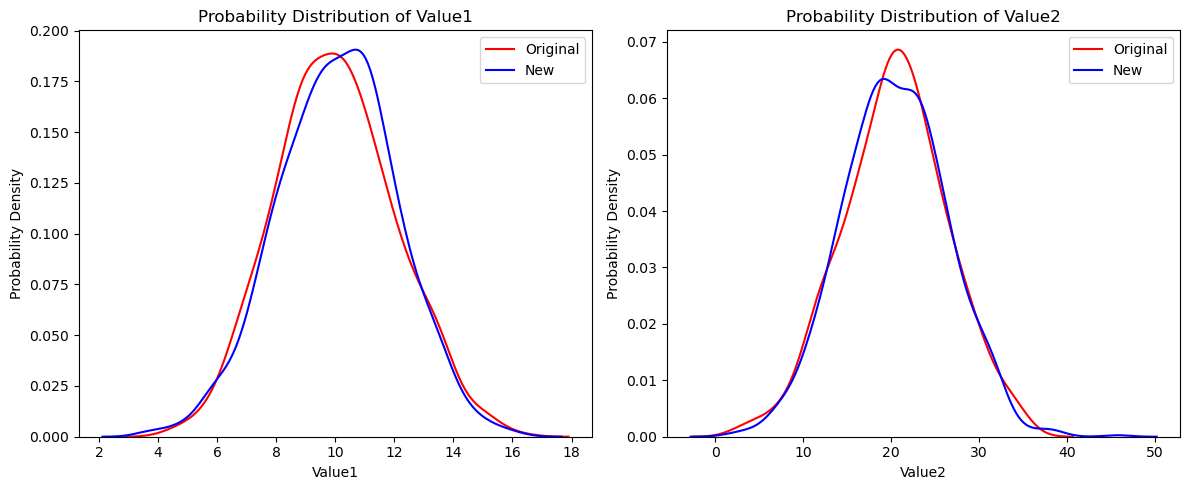

In [26]:
#8
plot_continuous_value_comparison(df_original,df_new)

In [27]:
#9
compare_descriptive_statistics(df_original,df_new)


====== Value1 Descriptive Statistics ======
       Original_Value1  New_Value1
count          500.000    1000.000
mean            10.015      10.077
std              2.014       2.007
min              4.606       3.629
25%              8.698       8.710
50%              9.935      10.090
75%             11.323      11.418
max             16.158      16.163

====== Value2 Descriptive Statistics ======
       Original_Value2  New_Value2
count          500.000    1000.000
mean            20.436      20.477
std              5.973       5.948
min              2.622       1.687
25%             16.385      16.479
50%             20.481      20.320
75%             24.249      24.418
max             35.478      45.689


In [28]:
#10
test_continuous_values_similarity(df_original,df_new)

Distributions of Value1 of two datasets are same as p_value=0.4220468755212404 and it is greater than 0.05

Distributions of Value2 of two datasets are same as p_value=0.7169192759164035 and it is greater than 0.05



In [29]:
#10
test_categorical_values_similarity(df_original,df_new)

Distribution of Category1 of two datasets are statistically similar as p_value=1.0 and it is greater than 0.05

